In [12]:
import wfdb
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier,ExtraTreesClassifier, BaggingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, hamming_loss,ConfusionMatrixDisplay,roc_curve, auc,roc_auc_score,precision_recall_curve
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import FunctionTransformer,StandardScaler
from mne.datasets import sample
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, StratifiedShuffleSplit,RandomizedSearchCV
from mne_features.feature_extraction import extract_features, FeatureExtractor
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest,f_classif
import neurokit2 as nk
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay,permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import seaborn as sns
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [117]:
#Import the extracted features
X_train=np.load("features_cleaned_120s_train.npy")
y_train=np.load("labels_cleaned_120s_train.npy")
X_test=np.load(r"features_cleaned_120s_test.npy")
y_test=np.load(r"labels_cleaned_120s_test.npy")

In [121]:
for i in [60,90,120]:
    X_train=np.load(f"features_cleaned_{i}s_train.npy")
    y_train=np.load(f"labels_cleaned_{i}s_train.npy")
    X_test=np.load(f"features_cleaned_{i}s_test.npy")
    y_test=np.load(f"labels_cleaned_{i}s_test.npy")
    # Ranking classifiers
    print(f"Testing for {i}s intervals")
    names = [
        "Nearest Neighbors",
        "Linear SVM",
        "RBF SVM",
        "Decision Tree",
        "Random Forest",
        "Neural Net",
        "AdaBoost",
        "Naive Bayes",
        "QDA",
        "XGBClassifier",
        "Logistic Regression",
        "LGBMClassifier",
        "CatBoostClassifier",
        "Extra Trees",
        "Bagging Classifier",
        "HistGradientBoosting"
    ]

    classifiers = [
        KNeighborsClassifier(3),
        SVC(kernel="linear", C=0.025, random_state=42),
        SVC(gamma=2, C=1, random_state=42),
        DecisionTreeClassifier(max_depth=5, random_state=42),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=42),
        AdaBoostClassifier(random_state=42),
        GaussianNB(),
        QuadraticDiscriminantAnalysis(),
        XGBClassifier(),
        LogisticRegression(random_state=42, max_iter=1000),
        LGBMClassifier(random_state=42),
        CatBoostClassifier(verbose=0, random_state=42),
        ExtraTreesClassifier(n_estimators=100, random_state=42),
        BaggingClassifier( random_state=42),
        HistGradientBoostingClassifier(random_state=42)
    ]

    results = {}

    for name, clf in zip(names, classifiers):
        pipe = make_pipeline(StandardScaler(), clf)
        scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
        results[name] = np.mean(scores)
        print(f"Average cross-validation accuracy of {name}: {np.mean(scores):.4f}")

    # Sort results by accuracy
    sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

    print("\nSorted Model Performance:")
    for name, score in sorted_results:
        print(f"{name}: {score:.4f}")

Testing for 60s intervals
Average cross-validation accuracy of Nearest Neighbors: 0.6886
Average cross-validation accuracy of Linear SVM: 0.7538
Average cross-validation accuracy of RBF SVM: 0.5956
Average cross-validation accuracy of Decision Tree: 0.7005
Average cross-validation accuracy of Random Forest: 0.7401
Average cross-validation accuracy of Neural Net: 0.7354
Average cross-validation accuracy of AdaBoost: 0.5668
Average cross-validation accuracy of Naive Bayes: 0.5568
Average cross-validation accuracy of QDA: 0.7274
Average cross-validation accuracy of XGBClassifier: 0.7532
Average cross-validation accuracy of Logistic Regression: 0.7406
Average cross-validation accuracy of LGBMClassifier: 0.7356
Average cross-validation accuracy of CatBoostClassifier: 0.7271
Average cross-validation accuracy of Extra Trees: 0.7159
Average cross-validation accuracy of Bagging Classifier: 0.7426

Sorted Model Performance:
Linear SVM: 0.7538
XGBClassifier: 0.7532
Bagging Classifier: 0.7426
Logi

In [124]:
# XGB is our choice since we suspect the relationships
#Import the extracted features
X_train=np.load("features_cleaned_120s_train.npy")
y_train=np.load("labels_cleaned_120s_train.npy")
X_test=np.load(r"features_cleaned_120s_test.npy")
y_test=np.load(r"labels_cleaned_120s_test.npy")
pipe = make_pipeline(StandardScaler(),
    XGBClassifier(random_state=42)
)

In [125]:
# Define hyperparameter search space
param_dist = {
    'xgbclassifier__max_depth': np.random.randint(3, 10, 5).tolist(),
    'xgbclassifier__learning_rate': np.linspace(0.01, 0.3, 6).tolist(),
    'xgbclassifier__gamma': np.linspace(0, 1, 5).tolist(),
    'xgbclassifier__n_estimators': np.random.randint(100, 600, 5).tolist(),
    'xgbclassifier__subsample': np.linspace(0.7, 1.0, 4).tolist(),
    'xgbclassifier__colsample_bytree': np.linspace(0.5, 1.0, 4).tolist(),
    'xgbclassifier__reg_lambda': np.logspace(-2, 1, 4).tolist(),
    'xgbclassifier__reg_alpha': np.logspace(-2, 1, 4).tolist(),
    'xgbclassifier__min_child_weight': np.random.randint(1, 6, 4).tolist(),
}
# Perform RandomizedSearchCV with 20 random samples
random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=20,  # Number of random parameter sets to test
    scoring='roc_auc',  # Use ROC AUC for imbalanced data
    n_jobs=-1,
    cv=5,  # 5-fold cross-validation
    verbose=3,
    random_state=42
)

# Fit RandomizedSearch
random_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best ROC AUC Score:", random_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'xgbclassifier__subsample': 0.7, 'xgbclassifier__reg_lambda': 0.1, 'xgbclassifier__reg_alpha': 0.1, 'xgbclassifier__n_estimators': 557, 'xgbclassifier__min_child_weight': 5, 'xgbclassifier__max_depth': 4, 'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__gamma': 1.0, 'xgbclassifier__colsample_bytree': 1.0}
Best ROC AUC Score: 0.8439957786462905


In [126]:
# we now check the performance of our model
pipe = make_pipeline(StandardScaler(),  XGBClassifier(
    subsample=1,
    reg_lambda=0.01,
    reg_alpha=10.0,
    n_estimators=171,
    min_child_weight=3,
    max_depth=4,
    learning_rate=0.126,
    gamma=0.5,
    colsample_bytree=1,
    random_state=42))
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8215968112090832
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86     10286
           1       0.80      0.71      0.75      6272

    accuracy                           0.82     16558
   macro avg       0.82      0.80      0.81     16558
weighted avg       0.82      0.82      0.82     16558



In [127]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=41)
scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy')
print("Cross-validation accuracy scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation accuracy scores: [0.87789281 0.87145903 0.87480963 0.86871764 0.86536704]
Mean accuracy: 0.8716492298011793


ROC AUC Score: 0.9021830246778859


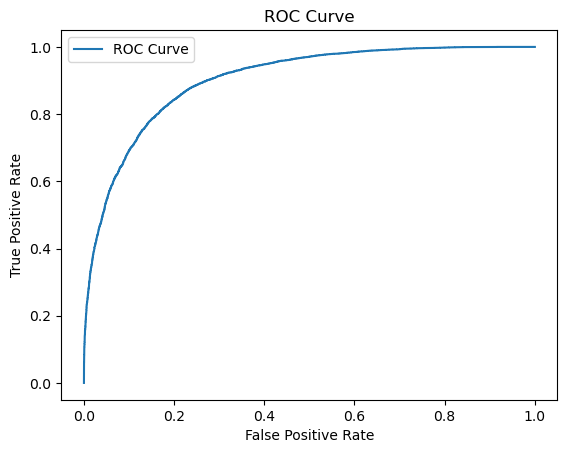

In [128]:
y_proba = pipe.predict_proba(X_test)[:, 1] 
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

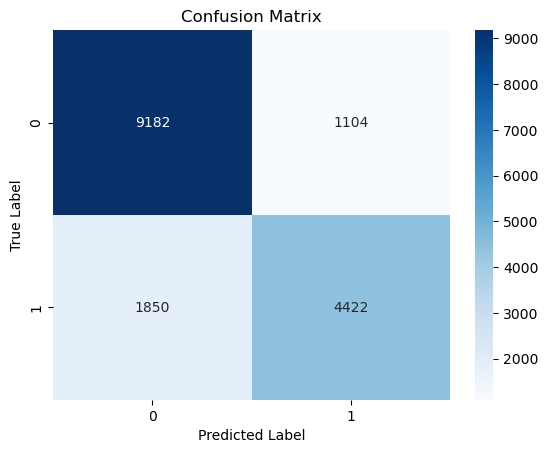

In [129]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [130]:
y_pred = pipe.predict(X_train)

# Evaluate performance
print("Accuracy:", accuracy_score(y_train, y_pred))
print("Classification Report:\n", classification_report(y_train, y_pred))

Accuracy: 0.9073464912280702
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.92      9922
           1       0.89      0.87      0.88      6494

    accuracy                           0.91     16416
   macro avg       0.90      0.90      0.90     16416
weighted avg       0.91      0.91      0.91     16416



In [131]:
# we check feature importance
xgb_model = pipe.named_steps['xgbclassifier']
feature_importances =sorted(list(zip(xgb_model.feature_importances_,range(65))))[::-1]
print(feature_importances)

[(0.10595569, 62), (0.086510934, 8), (0.0682436, 9), (0.054088205, 45), (0.0349585, 36), (0.033935692, 14), (0.032298777, 22), (0.028999992, 49), (0.027181307, 11), (0.026370455, 19), (0.026173674, 12), (0.024736535, 29), (0.02430051, 5), (0.022254368, 35), (0.02147597, 34), (0.020500328, 48), (0.019544583, 16), (0.016380413, 0), (0.01623184, 10), (0.01609794, 37), (0.014370319, 43), (0.014311908, 17), (0.013359159, 42), (0.012781357, 21), (0.012772749, 2), (0.0124092465, 15), (0.010278902, 6), (0.009906924, 41), (0.009451525, 57), (0.009325976, 25), (0.008243985, 63), (0.008212628, 64), (0.008186402, 56), (0.008076194, 4), (0.008047952, 61), (0.007649929, 55), (0.0072615454, 52), (0.0071607674, 46), (0.0068508177, 13), (0.006824708, 31), (0.0066308863, 28), (0.006493758, 30), (0.0061287573, 47), (0.005722999, 23), (0.0056973877, 33), (0.005677159, 50), (0.005337856, 1), (0.005173158, 60), (0.0050882255, 44), (0.004743181, 18), (0.004449065, 54), (0.0043460596, 24), (0.0042782454, 59),

In [132]:
data = nk.data("bio_resting_5min_100hz")
ecg_cleaned = nk.ecg_clean(data["ECG"], sampling_rate=100)
peaks, info = nk.ecg_peaks(ecg_cleaned[:60*100], sampling_rate=100, correct_artifacts=True)
hrv_indices = nk.hrv(peaks, sampling_rate=100)
nans=np.all(np.isnan(hrv_indices.to_numpy()),axis=0)
for i in feature_importances:
    print(hrv_indices.columns[~nans][i[1]])

HRV_HFD
HRV_MCVNN
HRV_IQRNN
HRV_SD1a
HRV_PSS
HRV_pNN20
HRV_TP
HRV_SD2a
HRV_Prc20NN
HRV_LF
HRV_Prc80NN
HRV_SD1SD2
HRV_CVSD
HRV_IALS
HRV_PIP
HRV_SD2d
HRV_MaxNN
HRV_MeanNN
HRV_SDRMSSD
HRV_PAS
HRV_C1a
HRV_HTI
HRV_C1d
HRV_VHF
HRV_RMSSD
HRV_MinNN
HRV_MedianNN
HRV_PI
HRV_FuzzyEn
HRV_HFn
HRV_KFD
HRV_LZC
HRV_ShanEn
HRV_CVNN
HRV_CD
HRV_SampEn
HRV_SDNNd
HRV_C2d
HRV_pNN50
HRV_CSI
HRV_SD2
HRV_S
HRV_C2a
HRV_LFHF
HRV_CSI_Modified
HRV_Cd
HRV_SDNN
HRV_RCMSEn
HRV_SD1d
HRV_TINN
HRV_ApEn
HRV_LFn
HRV_CMSEn
HRV_HF
HRV_AI
HRV_MadNN
HRV_GI
HRV_MSEn
HRV_SDNNa
HRV_Ca
HRV_SI
HRV_SDSD
HRV_CVI
HRV_SD1
HRV_LnHF
